# nb011

**各器官に対して別々のモデルを用意して予測精度を見てみる**
**stamach, large bowle, small bowel はそれぞれ形状がけっこう違うので専門のモデルを用意した方がよいかもしれない**

**細かい境界が大事になってくるので画像サイズは上げたい**

**stomach専門のモデル**

*  [UWMGI: 2.5D [Train] [PyTorch]](https://www.kaggle.com/code/awsaf49/uwmgi-2-5d-train-pytorch)
* **2.5D data**
* UNet


In [1]:
from google.colab import drive
drive.mount("/content/drive")
%cd /content/drive/MyDrive/kaggle/UWMGI/

# シンボリックリンクを作成
!ln -sfn /content/drive/MyDrive/kaggle/UWMGI/ /content/workspace

#!apt-get install vim
# kaggle api
!pip install kaggle
!pip install segmentation_models_pytorch
!pip install wandb

# current directory 変更
import os
# path を通す
import sys
sys.path.append("../")

# import したもの自動reloadする設定
%load_ext autoreload
%autoreload 2

os.environ["KAGGLE_CONFIG_DIR"] = "/content/workspace"

Mounted at /content/drive
/content/drive/MyDrive/kaggle/UWMGI
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 5.4 MB/s 
     |████████████████████████████████| 376 kB 56.7 MB/s 
     |████████████████████████████████| 58 kB 5.7 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=50ef298706c86c9308aabffba475612ecc8d4b380c64e611c6acaab041114df9
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=d0ba67aa6788bf8fec5c897ef5c44aa7b737f8613dce1471bd594ddcb231256d
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successf

In [2]:
import numpy as np
import pandas as pd
import random
from glob import glob
import os, shutil
import copy
from tqdm import tqdm_notebook as tqdm
import time
from collections import defaultdict
import gc
import h5py
import pdb

# visualization
import cv2 as cv
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Sklearn
from sklearn.model_selection import StratifiedKFold, KFold, StratifiedGroupKFold

# PyTorch 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp
import segmentation_models_pytorch as smp

# image deeplearning models library
import timm

# Albumentations for augmentations
import albumentations as album
#from albumentations.pytorch import ToTensorV2

from joblib import Parallel, delayed

import warnings
warnings.filterwarnings("ignore")

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# wandb
import wandb

In [3]:
class CFG:
    seed = 101
    debug = False
    exp_name = "nb011"
    model_name = "Unet"
    backbone = "efficientnet-b0"
    comment = "unet-efficientnet_b0-320*384-ep5-stomach"
    train_bs = 64 if debug == False else 20
    valid_bs = 128 if debug == False else 20
    img_size = [320, 384] # 実質img25Dそのもののサイズで学習を行っている [320, 384]
    channels = 3
    epochs = 7
    lr = 2e-3
    scheduler = "CosineAnnealingLR"
    min_lr = 1e-6
    T_max = int(30000 / train_bs * epochs) + 50
    T_0 = 25
    warmup_epochs = 0
    wd = 1e-6
    n_accumulate = max(1, 32 // train_bs)
    n_fold = 3
    num_classes = 1 # 3 -> 1 becase only predict one organ
    device = "cuda" if torch.cuda.is_available() else "cpu"

# environment variable
NUM_WORKERS = os.cpu_count()
HDF5_PATH = './data/dataset.hdf5'
# 学習高速化するが計算の再現性はなくなることに注意する
torch.backends.cudnn.benchmark = True

def class2dic(f):
        return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith("__"))


## Reproducibility

In [4]:
def set_seed(seed = 35):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    os.environ["PYTHONHASHSEED"] = str(seed)

set_seed(CFG.seed)

In [5]:
df = pd.read_csv("./data/train_v4.csv")
columns = ["id", "segmentation", "case", "day", "slice", "path", "image_height", "image_width", "exist_segmentation", "mask3D_path", "mask2D_path"]
df = df[columns]

# case7_day0, case81_day30はannotationのミスがあるらしい
case7_day0 = (df["case"] == 7) & (df["day"] == 0)
case81_day30 = (df["case"] == 81) & (df["day"] == 30)
df = df[~(case7_day0 | case81_day30)]
df = df.reset_index()

df["img_path"] = '/img25D/channel3-stride2-back/' + df["id"]
df["mask_path"] = '/mask25D/channel3-stride2-back/' + df["id"]
df.head()

,index,id,segmentation,case,day,slice,path,image_height,image_width,exist_segmentation,mask3D_path,mask2D_path,img_path,mask_path
0,0,case2_day1_slice_0001,NaN,2,1,1,./data/train/case2/case2_day1/scans/slice_0001...,266,266,False,./data/masks_png/case2_day1_slice_0001.png,./data/masks2D_png/case2_day1_slice_0001.png,/img25D/channel3-stride2-back/case2_day1_slice...,/mask25D/channel3-stride2-back/case2_day1_slic...
1,1,case2_day1_slice_0002,NaN,2,1,2,./data/train/case2/case2_day1/scans/slice_0002...,266,266,False,./data/masks_png/case2_day1_slice_0002.png,./data/masks2D_png/case2_day1_slice_0002.png,/img25D/channel3-stride2-back/case2_day1_slice...,/mask25D/channel3-stride2-back/case2_day1_slic...
2,2,case2_day1_slice_0003,NaN,2,1,3,./data/train/case2/case2_day1/scans/slice_0003...,266,266,False,./data/masks_png/case2_day1_slice_0003.png,./data/masks2D_png/case2_day1_slice_0003.png,/img25D/channel3-stride2-back/case2_day1_slice...,/mask25D/channel3-stride2-back/case2_day1_slic...
3,3,case2_day1_slice_0004,NaN,2,1,4,./data/train/case2/case2_day1/scans/slice_0004...,266,266,False,./data/masks_png/case2_day1_slice_0004.png,./data/masks2D_png/case2_day1_slice_0004.png,/img25D/channel3-stride2-back/case2_day1_slice...,/mask25D/channel3-stride2-back/case2_day1_slic...
4,4,case2_day1_slice_0005,NaN,2,1,5,./data/train/case2/case2_day1/scans/slice_0005...,266,266,False,./data/masks_png/case2_day1_slice_0005.png,./data/masks2D_png/case2_day1_slice_0005.png,/img25D/channel3-stride2-back/case2_day1_slice...,/mask25D/channel3-stride2-back/case2_day1_slic...


## Image

In [6]:
def load_img_3channels(path):
    img = cv.imread(path, cv.IMREAD_UNCHANGED)
    # gray -> 1 channel rgb -> 3 channels
    img = np.tile(img[..., None], [1, 1, 3])
    img = img.astype("float32")
    return img

def load_img(path):
    img = cv.imread(path, cv.IMREAD_UNCHANGED)
    img = cv.normalize(img, None, alpha = 0, beta = 255, 
                        norm_type = cv.NORM_MINMAX, dtype = cv.CV_32F)
    img = img.astype(np.uint8)
    return img

def load_mask(path):
    mask = cv.imread(path, cv.IMREAD_UNCHANGED)
    mask = mask.astype("float32")
    return mask

def load_data_from_hdf5(path, hdf5_file_path):
    """
    path: path in the hdf5 file
    hdf5_file_path: path of the hdf5 file
    """
    f = h5py.File(hdf5_file_path, 'r')
    img = f[path][...]
    f.close()
    img = img.astype(np.float)
    mx = np.max(img)
    # scale image to [0, 1]
    if mx:
        img /= mx
    return img

def normalize_img(img):
    img = img.astype(np.float)
    mx = img.max()
    if mx:
        img /= mx
    return img
    
def convert_img_1channel_to_3channels(img):
    """
    img (numpy array): img of 1 channels (gray scale)
    return res (numpy array): img of 3 channels (3 channels)
    """
    res = np.tile(img[..., None], [1, 1, 3])
    return res

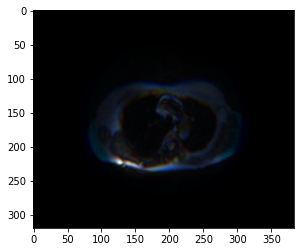

In [7]:
# test load_img_from_hdf5
path = '/img25D/channel3-stride2-back/case2_day1_slice_0001'
img = load_data_from_hdf5(path, HDF5_PATH)
plt.imshow(img)

## visualization

In [8]:
# Yellow Purple Red
labels = ["Large Bowel", "Small Bowel", "Stomach"]

import matplotlib.colors as colors
from matplotlib.colors import LinearSegmentedColormap

# Custom color map in matplotlib
mask_colors = [(1.0, 0.7, 0.1), (1.0, 0.5, 1.0), (1.0, 0.22, 0.099)]
legend_colors = [Rectangle((0,0),1,1, color=color) for color in mask_colors]

def CustomCmap(rgb_color):

    r1,g1,b1 = rgb_color

    cdict = {'red': ((0, r1, r1),
                   (1, r1, r1)),
           'green': ((0, g1, g1),
                    (1, g1, g1)),
           'blue': ((0, b1, b1),
                   (1, b1, b1))}

    cmap = LinearSegmentedColormap('custom_cmap', cdict)
    # １以外の部分は表示しない
    cmap_lis = cmap(np.arange(cmap.N))
    cmap_lis[:, 3] = 0
    cmap_lis[-1, 3] = 1
    cmap = colors.ListedColormap(cmap_lis)
    return cmap

CMAP1 = CustomCmap(mask_colors[0])
CMAP2 = CustomCmap(mask_colors[1])
CMAP3 = CustomCmap(mask_colors[2])

def plot_original_mask(img, mask, alpha=1):
    # Change pixels - when 1 make True, when 0 make NA
    # Split the channels
    mask_largeB = mask[:, :, 0]
    mask_smallB = mask[:, :, 1]
    mask_stomach = mask[:, :, 2]

    # Plot the 2 images (Original and with Mask)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    # Original
    ax1.set_title("Original Image")
    ax1.imshow(img, cmap="gist_gray")
    ax1.axis("off")

    # With Mask
    ax2.set_title("Image with Mask")
    ax2.imshow(img, cmap="gist_gray")
    ax2.imshow(mask_largeB, interpolation='none', cmap=CMAP1, alpha=alpha)
    ax2.imshow(mask_smallB, interpolation='none', cmap=CMAP2, alpha=alpha)
    ax2.imshow(mask_stomach, interpolation='none', cmap=CMAP3, alpha=alpha)
    ax2.legend(legend_colors, labels)
    ax2.axis("off")
    
    fig.show()

def plot_img_and_mask(img, mask, alpha=1, ax=None):
    mask_largeB = mask[:, :, 0]
    mask_smallB = mask[:, :, 1]
    mask_stomach = mask[:, :, 2]
    
    if (ax == None):
        fig, ax = plt.subplots(figsize=(5, 5))

    ax.imshow(img, cmap="gist_gray")
    ax.imshow(mask_largeB, interpolation='none', cmap=CMAP1, alpha=alpha)
    ax.imshow(mask_smallB, interpolation='none', cmap=CMAP2, alpha=alpha)
    ax.imshow(mask_stomach, interpolation='none', cmap=CMAP3, alpha=alpha)
    ax.legend(legend_colors, labels)
    ax.axis("off")

def plot_multiple_img_and_mask(id_list, hdf5_path=HDF5_PATH, alpha=1):
    file = h5py.File(hdf5_path, 'r')
    n = len(id_list)

    rows, cols = 5, n + 4 // 5
    fig, axes = plt.subplots(rows, cols, figsize=(5 * rows, 5 * cols))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if (i < n):
            id = id_list[i]
            img = file['img'][id][...]
            mask = file['mask3D'][id][...]
            plot_img_and_mask(img, mask, ax=ax)
        else:
            ax.set_visible(False)
    return

### check img and mask3D
### check img2.5D and mas2.5D

(266, 266) (266, 266, 3)


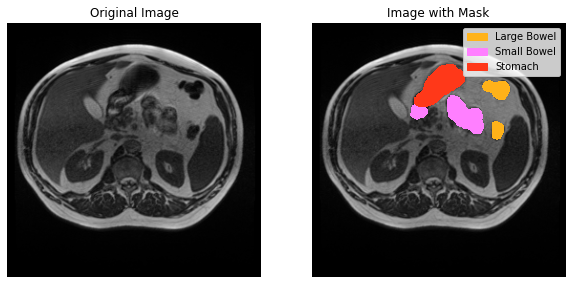

In [9]:
#img_path = "./data/train/case2/case2_day1/scans/slice_0059_266_266_1.50_1.50.png"
#mask_path = "./data/masks_png/case2_day1_slice_0059.png"
id = 'case123_day20_slice_0090'
img_path_in_hdf5 = f'img/{id}'
mask_path_in_hdf5 = f'mask3D/{id}'
img = load_data_from_hdf5(img_path_in_hdf5, HDF5_PATH)
mask = load_data_from_hdf5(mask_path_in_hdf5, HDF5_PATH)
plot_original_mask(img, mask)
print(img.shape, mask.shape)

(320, 384, 3) (320, 384, 3)


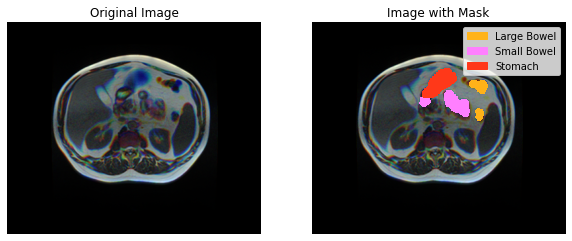

In [10]:
id = 'case123_day20_slice_0090'
img_path_in_hdf5 = f'img25D/channel3-stride2-back/{id}'
mask_path_in_hdf5 = f'mask25D/channel3-stride2-back/{id}'
img = load_data_from_hdf5(img_path_in_hdf5, HDF5_PATH)
mask = load_data_from_hdf5(mask_path_in_hdf5, HDF5_PATH)
plot_original_mask(img, mask)
print(img.shape, mask.shape)

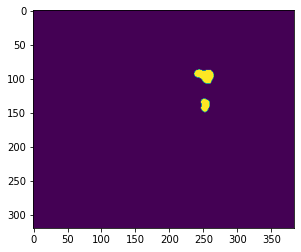

In [11]:
# mask[:, :, 0] -> large bowel, mask[:, :, 1] -> small bowel, mask[:, :, 2] -> stomach
plt.imshow(mask[:, :, 0])

## Create Folds

In [12]:
fold_df = pd.read_csv("./data/id-fold.csv")
df = pd.merge(df, fold_df, on="id", how="left")
df.head()

,index,id,segmentation,case,day,slice,path,image_height,image_width,exist_segmentation,mask3D_path,mask2D_path,img_path,mask_path,fold
0,0,case2_day1_slice_0001,NaN,2,1,1,./data/train/case2/case2_day1/scans/slice_0001...,266,266,False,./data/masks_png/case2_day1_slice_0001.png,./data/masks2D_png/case2_day1_slice_0001.png,/img25D/channel3-stride2-back/case2_day1_slice...,/mask25D/channel3-stride2-back/case2_day1_slic...,2
1,1,case2_day1_slice_0002,NaN,2,1,2,./data/train/case2/case2_day1/scans/slice_0002...,266,266,False,./data/masks_png/case2_day1_slice_0002.png,./data/masks2D_png/case2_day1_slice_0002.png,/img25D/channel3-stride2-back/case2_day1_slice...,/mask25D/channel3-stride2-back/case2_day1_slic...,2
2,2,case2_day1_slice_0003,NaN,2,1,3,./data/train/case2/case2_day1/scans/slice_0003...,266,266,False,./data/masks_png/case2_day1_slice_0003.png,./data/masks2D_png/case2_day1_slice_0003.png,/img25D/channel3-stride2-back/case2_day1_slice...,/mask25D/channel3-stride2-back/case2_day1_slic...,2
3,3,case2_day1_slice_0004,NaN,2,1,4,./data/train/case2/case2_day1/scans/slice_0004...,266,266,False,./data/masks_png/case2_day1_slice_0004.png,./data/masks2D_png/case2_day1_slice_0004.png,/img25D/channel3-stride2-back/case2_day1_slice...,/mask25D/channel3-stride2-back/case2_day1_slic...,2
4,4,case2_day1_slice_0005,NaN,2,1,5,./data/train/case2/case2_day1/scans/slice_0005...,266,266,False,./data/masks_png/case2_day1_slice_0005.png,./data/masks2D_png/case2_day1_slice_0005.png,/img25D/channel3-stride2-back/case2_day1_slice...,/mask25D/channel3-stride2-back/case2_day1_slic...,2


## Dataset

In [13]:
class BuildDataset(Dataset):
    def __init__(self, df, label=True, transforms=None, hdf5_path=HDF5_PATH):
        self.df = df
        self.label = label
        self.ids = df["id"].tolist()
        self.img_paths = df["img_path"].tolist()
        self.mask_paths = df["mask_path"].tolist()
        self.transforms = transforms
        self.f = h5py.File(hdf5_path, 'r')
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = self.f[img_path][...]
        # range [0, 1]
        img = normalize_img(img)
        if (len(img.shape) == 2):
            # 1 channel -> 3 channels
            img = convert_img_1channel_to_3channels(img)

        if self.label:
            mask_path = self.mask_paths[idx]
            msk = self.f[mask_path][...]
            msk = msk.astype(np.float)
            # 2 -> stomach
            msk = msk[:, :, 2][:, :, None]
            if self.transforms(image=img, mask=msk):
                data = self.transforms(image=img, mask=msk)
                img = data["image"]
                msk = data["mask"]
            img = np.transpose(img, (2, 0, 1))
            msk = np.transpose(msk, (2, 0, 1))
            return torch.tensor(img), torch.tensor(msk)
        else:
            if self.transforms:
                data = self.transforms(image=img)
                img = data["image"]
            img = np.transpose(img, (2, 0, 1))
            return torch.tensor(img)


## Augumentations

In [14]:
data_transforms = {
    "train": album.Compose([
 #       album.Resize(*CFG.img_size, interpolation=cv.INTER_NEAREST, p=1.0),
        album.HorizontalFlip(p=0.5),
 #       album.VerticalFlip(p=0.5),
        album.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=10, p=0.5),
        album.OneOf([
            album.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
            album.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0),
        ], p=0.25)
    ], p=1.0),
    "valid": album.Compose([
 #       album.Resize(*CFG.img_size, interpolation=cv.INTER_NEAREST)
    ], p=1.0)
}

## DataLoader

In [15]:
def prepare_loaders(fold, debug=False):
    train_df = df.query("fold != @fold").reset_index(drop=True)
    valid_df = df.query("fold == @fold").reset_index(drop=True)

    if debug:
        train_df = train_df.head(32*5)
        valid_df = train_df.head(32*5)
    
    train_dataset = BuildDataset(train_df, transforms=data_transforms["train"])
    valid_dataset = BuildDataset(valid_df, transforms=data_transforms["valid"])

    train_loader = DataLoader(train_dataset,
                              batch_size = CFG.train_bs,
                              num_workers = NUM_WORKERS,
                              shuffle = True,
                              pin_memory = True,
                              drop_last = False)
    valid_loader = DataLoader(valid_dataset,
                              batch_size = CFG.valid_bs,
                              num_workers = NUM_WORKERS,
                              shuffle = False,
                              pin_memory = True)
    return train_loader, valid_loader

## Loss Function

In [16]:
JaccardLoss = smp.losses.JaccardLoss(mode='multilabel')
DiceLoss    = smp.losses.DiceLoss(mode='multilabel')
BCELoss     = smp.losses.SoftBCEWithLogitsLoss()
LovaszLoss  = smp.losses.LovaszLoss(mode='multilabel', per_image=False)
TverskyLoss = smp.losses.TverskyLoss(mode='multilabel', log_loss=False)

def dice_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    dice = ((2*inter+epsilon)/(den+epsilon)).mean(dim=(1,0))
    return dice

def iou_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    union = (y_true + y_pred - y_true*y_pred).sum(dim=dim)
    iou = ((inter+epsilon)/(union+epsilon)).mean(dim=(1,0))
    return iou

def criterion(y_pred, y_true):
    return 0.5*BCELoss(y_pred, y_true) + 0.5*TverskyLoss(y_pred, y_true)

## Model

In [17]:
def build_model():
    model = smp.Unet(encoder_name=CFG.backbone,
                     encoder_weights="imagenet",
                     in_channels=CFG.channels,
                     classes=CFG.num_classes,
                     activation=None)
    model.to(CFG.device)
    return model

def load_model(path):
    model = build_model()
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

## Optimizer

In [18]:
def get_scheduler(optimizer):
    if CFG.scheduler == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,
                                                   T_max=CFG.T_max,
                                                   eta_min=CFG.min_lr)
    elif CFG.scheduler == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,
                                                             T_0=CFG.T_0,
                                                             eta_min=CFG.min_lr)
    elif CFG.scheduler == 'ReduceLROnPlateau':
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,
                                                   mode='min',
                                                   factor=0.1,
                                                   patience=7,
                                                   threshold=0.0001,
                                                   min_lr=CFG.min_lr)
    elif CFG.scheduer == 'ExponentialLR':
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.85)
    
    elif CFG.scheduler == None:
        return None
        
    return scheduler

In [19]:
# test dataloader
train_loader, valid_laoder= prepare_loaders(fold=0, debug=True)
data_iter = iter(train_loader)
imgs, masks = data_iter.next()
print(imgs.shape)
print(masks.shape)

torch.Size([64, 3, 320, 384])
torch.Size([64, 1, 320, 384])


[0.         0.00135501 0.00171233 ... 0.99143833 0.99635702 1.        ]
[0. 1.]


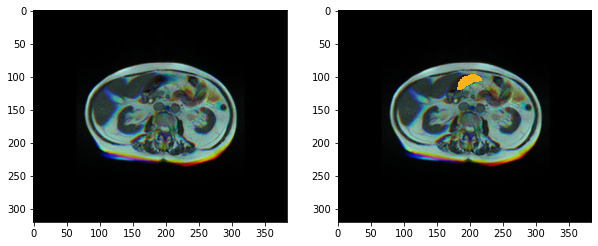

In [20]:
idx = 6
img = imgs[idx].permute(1, 2, 0).numpy()
mask = masks[idx].permute(1, 2, 0).squeeze(-1).numpy()

fig, axes = plt.subplots(1, 2, figsize=(2 * 5, 5))
axes[0].imshow(img)
axes[1].imshow(img)
axes[1].imshow(mask, cmap=CMAP1)
print(np.unique(img))
print(np.unique(mask))

In [21]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    scaler = amp.GradScaler()

    dataset_size = 0
    running_loss = 0.0

    pbar = tqdm(enumerate(dataloader), total = len(dataloader), desc = 'Train ')
    for step, (imgs, masks) in pbar:
        imgs = imgs.to(device, non_blocking=True, dtype=torch.float)
        masks = masks.to(device, non_blocking=True, dtype=torch.float)

        with amp.autocast(enabled = True):
            y_pred = model(imgs)
            loss = criterion(y_pred, masks)
            loss = loss / CFG.n_accumulate
        
        scaler.scale(loss).backward()

        if (step + 1) % CFG.n_accumulate == 0:
            scaler.step(optimizer)
            scaler.update()
            
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
        
        #grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        batch_size = imgs.size(0)
        running_loss += loss.item() * batch_size
        dataset_size += batch_size
        epoch_loss = running_loss / dataset_size

        mem = torch.cuda.memory_reserved() / 1e9 \
                    if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]["lr"]
        pbar.set_postfix(train_loss = f'{epoch_loss: 0.4f}',
                         lr = f'{current_lr: 0.5f}',
                         gpu_memory = f'{mem: 0.2f} GB')
    
    torch.cuda.empty_cache()
    gc.collect()

    return epoch_loss


In [22]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()

    running_loss = 0.0
    dataset_size = 0

    val_scores = []

    pbar = tqdm(enumerate(dataloader), total = len(dataloader), desc = 'Valid ')
    for step, (imgs, masks) in pbar:
        imgs = imgs.to(CFG.device, non_blocking=True, dtype=torch.float)
        masks = masks.to(CFG.device, non_blocking=True, dtype=torch.float)

        y_pred = model(imgs)
        loss = criterion(y_pred, masks)

        batch_size = imgs.size(0)
        running_loss += loss.item() * batch_size
        dataset_size += batch_size

        epoch_loss = running_loss / dataset_size

        y_pred = nn.Sigmoid()(y_pred)
        val_dice = dice_coef(masks, y_pred).cpu().detach().numpy()
        val_jaccard = iou_coef(masks, y_pred).cpu().detach().numpy()
        val_scores.append([val_dice, val_jaccard])

        mem = torch.cuda.memory_reserved() / 1e9 if torch.cuda.is_available() else 0
        pbar.set_postfix(valid_loss = f'{epoch_loss: 0.4f}',
                         gpu_memory = f'{mem: 0.2f} GB')
        
    val_scores = np.mean(val_scores, axis=0)
    torch.cuda.empty_cache()
    gc.collect()

    return epoch_loss, val_scores


In [23]:
def run_training(model, optimizer, scheduler, device, fold):
    # to automatically log gradients
    wandb.watch(model, log_freq = 100)

    # train_loader, valid_loader
    train_loader, valid_loader = prepare_loaders(fold = fold, debug = CFG.debug)

    start = time.time()
    best_models_wts = copy.deepcopy(model.state_dict())
    best_dice = -np.inf
    best_epoch = -1
    # 指定していないkeyを参照してもerrorでない
    history = defaultdict(list)

    for epoch in range(1, CFG.epochs + 1):
        gc.collect()
        print(f"Epoch {epoch} / {CFG.epochs}", end="")
        
        train_loss = train_one_epoch(model, optimizer, scheduler, train_loader, device, epoch)
        val_loss, val_scores = valid_one_epoch(model, valid_loader, device, epoch)
        val_dice, val_jaccard = val_scores

        history["Train Loss"].append(train_loss)
        history["Valid Loss"].append(val_loss)
        history["Valid Dice"].append(val_dice)
        history["Valid Jaccard"].append(val_jaccard)

        # log the metrics
        wandb.log({f"[fold{fold}] Train Loss": train_loss,
                   f"[fold{fold}] Valid Loss": val_loss,
                   f"[fold{fold}] Valid Dice": val_dice,
                   f"[fold{fold}] Valid Jaccrad": val_jaccard,
                   f"[fold{fold}] LR": scheduler.get_last_lr()[0]})
        
        print(f"Valid Dice: {val_dice: 0.4f} | Valid Jaccard: {val_jaccard: 0.4f}")

        if val_dice >= best_dice:
            print(f"Valid Score Improved ({best_dice: 0.4f} ---> {val_dice: 0.4f})")
            best_dice = val_dice
            best_jaccard = val_jaccard
            best_epoch = epoch
            wandb.run.summary["Best Dice"] = best_dice
            wandb.run.summary["Best Jaccard"] = best_jaccard
            wandb.run.summary["Best Epoch"] = best_epoch
            best_model_wts = copy.deepcopy(model.state_dict())
            save_path_dir = f"./model/{CFG.exp_name}"
            if (os.path.exists(save_path_dir) == False):
                os.mkdir(save_path_dir)
            save_file_name = f"{CFG.exp_name}-{fold}-best.bin"
            save_path = os.path.join(save_path_dir, save_file_name)
            torch.save(model.state_dict(), save_path)
            
    end = time.time()
    time_elapsed = end - start
    print("Training complete in {:.0f}h {:.0f}m {:.0f}s".format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60)
    )
    print("Best Score: {:.4f}".format(best_jaccard))

    model.load_state_dict(best_model_wts)
    history = pd.DataFrame(history)

    return model, history

In [24]:
wandb.init(project = 'UW-Maddison-GI-Tract',
                  config = class2dic(CFG),
                  name = CFG.exp_name,
                  group = CFG.comment)

for fold in range(CFG.n_fold):
    print('#' * 15)
    print(f'Fold: {fold}')
    print('#' * 15)

    model = build_model()
    optimizer = optim.Adam(model.parameters(), lr = CFG.lr, weight_decay = CFG.wd)
    scheduler = get_scheduler(optimizer)
    model, history = run_training(model, optimizer, scheduler, CFG.device, fold)
    
wandb.finish()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


###############
Fold: 0
###############


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

Epoch 1 / 7

Train :   0%|          | 0/408 [00:00<?, ?it/s]

Valid :   0%|          | 0/95 [00:00<?, ?it/s]

Valid Dice:  0.7296 | Valid Jaccard:  0.7056
Valid Score Improved (-inf --->  0.7296)
Epoch 2 / 7

Train :   0%|          | 0/408 [00:00<?, ?it/s]

Valid :   0%|          | 0/95 [00:00<?, ?it/s]

Valid Dice:  0.8947 | Valid Jaccard:  0.8764
Valid Score Improved ( 0.7296 --->  0.8947)
Epoch 3 / 7

Train :   0%|          | 0/408 [00:00<?, ?it/s]

Valid :   0%|          | 0/95 [00:00<?, ?it/s]

Valid Dice:  0.9332 | Valid Jaccard:  0.9144
Valid Score Improved ( 0.8947 --->  0.9332)
Epoch 4 / 7

Train :   0%|          | 0/408 [00:00<?, ?it/s]

Valid :   0%|          | 0/95 [00:00<?, ?it/s]

Valid Dice:  0.9248 | Valid Jaccard:  0.9072
Epoch 5 / 7

Train :   0%|          | 0/408 [00:00<?, ?it/s]

Valid :   0%|          | 0/95 [00:00<?, ?it/s]

Valid Dice:  0.9386 | Valid Jaccard:  0.9206
Valid Score Improved ( 0.9332 --->  0.9386)
Epoch 6 / 7

Train :   0%|          | 0/408 [00:00<?, ?it/s]

Valid :   0%|          | 0/95 [00:00<?, ?it/s]

Valid Dice:  0.9380 | Valid Jaccard:  0.9198
Epoch 7 / 7

Train :   0%|          | 0/408 [00:00<?, ?it/s]

Valid :   0%|          | 0/95 [00:00<?, ?it/s]

Valid Dice:  0.9409 | Valid Jaccard:  0.9231
Valid Score Improved ( 0.9386 --->  0.9409)
Training complete in 1h 18m 10s
Best Score: 0.9231
###############
Fold: 1
###############
Epoch 1 / 7

Train :   0%|          | 0/382 [00:00<?, ?it/s]

Valid :   0%|          | 0/108 [00:00<?, ?it/s]

Valid Dice:  0.2608 | Valid Jaccard:  0.2341
Valid Score Improved (-inf --->  0.2608)
Epoch 2 / 7

Train :   0%|          | 0/382 [00:00<?, ?it/s]

Valid :   0%|          | 0/108 [00:00<?, ?it/s]

Valid Dice:  0.8823 | Valid Jaccard:  0.8648
Valid Score Improved ( 0.2608 --->  0.8823)
Epoch 3 / 7

Train :   0%|          | 0/382 [00:00<?, ?it/s]

Valid :   0%|          | 0/108 [00:00<?, ?it/s]

Valid Dice:  0.9029 | Valid Jaccard:  0.8871
Valid Score Improved ( 0.8823 --->  0.9029)
Epoch 4 / 7

Train :   0%|          | 0/382 [00:00<?, ?it/s]

Valid :   0%|          | 0/108 [00:00<?, ?it/s]

Valid Dice:  0.9304 | Valid Jaccard:  0.9120
Valid Score Improved ( 0.9029 --->  0.9304)
Epoch 5 / 7

Train :   0%|          | 0/382 [00:00<?, ?it/s]

Valid :   0%|          | 0/108 [00:00<?, ?it/s]

Valid Dice:  0.9311 | Valid Jaccard:  0.9128
Valid Score Improved ( 0.9304 --->  0.9311)
Epoch 6 / 7

Train :   0%|          | 0/382 [00:00<?, ?it/s]

Valid :   0%|          | 0/108 [00:00<?, ?it/s]

Valid Dice:  0.9324 | Valid Jaccard:  0.9146
Valid Score Improved ( 0.9311 --->  0.9324)
Epoch 7 / 7

Train :   0%|          | 0/382 [00:00<?, ?it/s]

Valid :   0%|          | 0/108 [00:00<?, ?it/s]

Valid Dice:  0.9390 | Valid Jaccard:  0.9210
Valid Score Improved ( 0.9324 --->  0.9390)
Training complete in 1h 11m 49s
Best Score: 0.9210
###############
Fold: 2
###############
Epoch 1 / 7

Train :   0%|          | 0/405 [00:00<?, ?it/s]

Valid :   0%|          | 0/97 [00:00<?, ?it/s]

Valid Dice:  0.7749 | Valid Jaccard:  0.7531
Valid Score Improved (-inf --->  0.7749)
Epoch 2 / 7

Train :   0%|          | 0/405 [00:00<?, ?it/s]

Valid :   0%|          | 0/97 [00:00<?, ?it/s]

Valid Dice:  0.9101 | Valid Jaccard:  0.8933
Valid Score Improved ( 0.7749 --->  0.9101)
Epoch 3 / 7

Train :   0%|          | 0/405 [00:00<?, ?it/s]

Valid :   0%|          | 0/97 [00:00<?, ?it/s]

Valid Dice:  0.8910 | Valid Jaccard:  0.8695
Epoch 4 / 7

Train :   0%|          | 0/405 [00:00<?, ?it/s]

Valid :   0%|          | 0/97 [00:00<?, ?it/s]

Valid Dice:  0.9364 | Valid Jaccard:  0.9184
Valid Score Improved ( 0.9101 --->  0.9364)
Epoch 5 / 7

Train :   0%|          | 0/405 [00:00<?, ?it/s]

Valid :   0%|          | 0/97 [00:00<?, ?it/s]

Valid Dice:  0.9450 | Valid Jaccard:  0.9266
Valid Score Improved ( 0.9364 --->  0.9450)
Epoch 6 / 7

Train :   0%|          | 0/405 [00:00<?, ?it/s]

Valid :   0%|          | 0/97 [00:00<?, ?it/s]

Valid Dice:  0.9466 | Valid Jaccard:  0.9285
Valid Score Improved ( 0.9450 --->  0.9466)
Epoch 7 / 7

Train :   0%|          | 0/405 [00:00<?, ?it/s]

Valid :   0%|          | 0/97 [00:00<?, ?it/s]

Valid Dice:  0.9478 | Valid Jaccard:  0.9293
Valid Score Improved ( 0.9466 --->  0.9478)
Training complete in 1h 14m 28s
Best Score: 0.9293


[fold0] LR,█▇▆▅▃▂▁
[fold0] Train Loss,█▃▂▂▁▁▁
[fold0] Valid Dice,▁▆█▇███
[fold0] Valid Jaccrad,▁▆█▇███
[fold0] Valid Loss,█▅▂▃▂▁▁
[fold1] LR,█▇▆▅▃▂▁
[fold1] Train Loss,█▄▃▂▁▁▁
[fold1] Valid Dice,▁▇█████
[fold1] Valid Jaccrad,▁▇█████
[fold1] Valid Loss,█▄▃▂▁▁▁
[fold2] LR,█▇▆▅▃▂▁
